### Exercise 1

![Image Title](assignment2.png)


In this assignment you will use the same imbalanced data set taken from MNIST as you did in 
Assignment #1. The t-SNE’d version of a randomy different version of similar data is shown above.
For this assignment you will
1) implement your own version of the Fuzzy C-Means clustering algorithm, “from scratch”.
2) you will apply this to both the dataset in the file (with 784 dimensions), as well as a PCA’d version of 
the data where you’ve reduced the dimensionality down to 2.
3) you will then write your own version of the Adjusted Rand Index algorithm (from scratch), and use it 
to score the results of your clustering on both versions of the data.
NOTE: you do not need to write PCA from scratch.
You will turn in both the code and a short report, discussing what you’ve implemented, how well it 
worked, what you’ve learned, etc. Remember, you must understand what you turn in – you may be 
asked to explain it to me and/or the class.
NOTE: Do not just comment your code and then turn that in as your report. I will deduct points. Your 
report will usually have at least a couple of pages of text, figures, etc

In [14]:
from bidict import bidict
from datetime import datetime
import numpy as np
from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn import datasets, metrics

google = False
data_path = 'G:/My Drive/csc730'

In [15]:
# %matplotlib qt

In [16]:
if google == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !ls "/content/drive/"

In [17]:
X_y = np.load('../data/skewed_MNIST.npy')
X = X_y[:,:-1]
y = X_y[:,-1]
print(X.shape,y.shape)

(12244, 784) (12244,)


probability=array([0.01559948, 0.00187847, 0.03128063, 0.50073505, 0.25032669,
       0.0077589 , 0.06256125, 0.0008984 , 0.00383861, 0.12512251]) bins=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]) counts=array([ 191,   23,  383, 6131, 3065,   95,  766,   11,   47, 1532],
      dtype=int64)


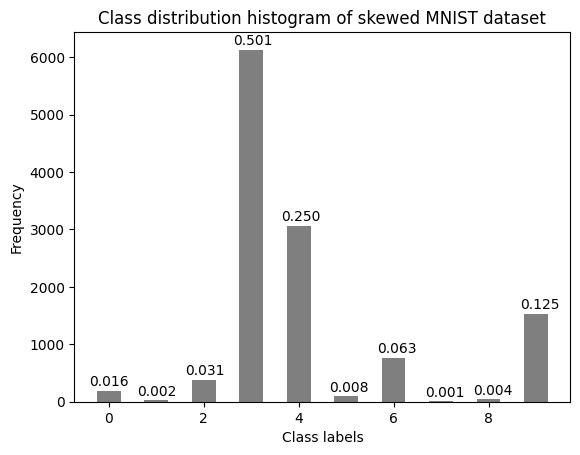

In [18]:
#original
#plt.hist(y)
#plt.xlabel('Class labels')
#plt.ylabel('frequency')

#modified qqqxxx
plt.hist(y, bins=np.linspace(0,10,11), align='left', rwidth=0.5, color='black', alpha=0.5)
plt.xlabel('Class labels')
plt.ylabel('Frequency')
plt.title('Class distribution histogram of skewed MNIST dataset')

probability, bins = np.histogram(y, bins=np.linspace(0,10,11), density=True)
counts, bins = np.histogram(y, bins=np.linspace(0,10,11))

print(f'{probability=} {bins=} {counts=}')

for i in range(len(probability)):
    plt.text(bins[i]+i/100, counts[i]+30, f'{probability[i]:.3f}', ha='center', va='bottom')

plt.savefig('./report/images/class_histogram.png', dpi=300)
plt.show()


### Fuzzy CMeans Clustering

In [19]:
print(f'{X[1]=}')
print(f'{X[2]=}')
print(np.linalg.norm(X[1]-X[2]))
print(distance.euclidean(X[1],X[2]))


X[1]=array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0

Implement fuzzy-cmeans from scratch

The paper this will be implmented from is titled: 'A Survey of Clustering Algorithms for Big Data: Taxonomy and Empirical Analysis'


[1]  
FCM pseudo-code:  
Input: Given the dataset, set the desire number of clusters c, the fuzzy parameter m (a constant > 1), and the stopping condition, initialize the fuzzy partition matrix, and set stop = false.  
Step 1. Do:  
Step 2. Calculate the cluster centroids and the objective value J.  
$\LARGE{v_{k}=\frac{\sum_{i=1}^n{{\mu^{m}_{{i}{k}}{\bold{\underline{p_{i}}}}}}}{\sum_{i=1}^n{{\mu^{m}_{{i}{k}}}}}}$ 
   
     
$\LARGE{{\vert\bold{\underline{p_{i}}}-\bold{\underline{v_{k}}}\vert}=\sqrt{\sum_{i=1}^{n}{(\bold{\underline{x_{i}}}-\bold{\underline{v_{k}}})^2}}}$  
  

$\LARGE{J=\sum_{i=1}^{n}{\sum_{k=1}^{c}{\mu^{m}_{{i}{k}}{\vert\bold{\underline{p_{i}}}-\bold{\underline{v_{k}}}\vert^{2}}}}}$  
  

Step 3. Compute the membership values stored in the matrix.  

$\LARGE{{\mu^{m}_{{i}{k}}}=\frac{1}{\sum_{l=1}^{c}{(\frac{{\vert\bold{\underline{p_{i}}}-\bold{\underline{v_{k}}}\vert^{2}}}{{\vert\bold{\underline{p_{i}}}-\bold{\underline{v_{l}}}\vert^{2}}})}^{\frac{2}{m-1}}}}$
  
    
Step 4. If the value of J between consecutive iterations is less than the stopping condition, then stop = true.  
Step 5. While (!stop)  
Output: A list of c cluster centres and a partition matrix are produced.  
  
References:
[1] Fahad, A., Alshatri, N., Tari, Z., Alamri, A., Khalil, I., Zomaya, A. Y., ... & Bouras, A. (2014). A survey of clustering algorithms for big data: Taxonomy and empirical analysis. IEEE transactions on emerging topics in computing, 2(3), 267-279.

In [20]:
# Implment fuzzy c-means clustering from scratch

def generate_mu(p, n_clusters, random_state=42):
    np.random.seed(random_state)
    #U = np.random.rand(p.shape[0],n_clusters)
    U = np.random.uniform(low=0.25, high=1, size=(p.shape[0], n_clusters))
    U = np.array([U[i,:] / np.sum(U[i,:], axis=0) for i in range(U.shape[0])])
    return U

def update_mu(p, mu, v,  m):
    for i in range(p.shape[0]):
        for k in range(mu.shape[1]):
             mu[i,k] = 0
             numerator = np.linalg.norm(p[i,:]-v[k,:])
             for l in range(mu.shape[1]):
                 denominator = np.linalg.norm(p[i,:]-v[l,:])
                 mu[i,k] += np.float_power(numerator/denominator,(2/(m-1)))
             mu[i,k] = 1 / mu[i,k]
                           
    return mu
   

def calculate_v(p, mu, m):
    v =  np.zeros(shape = (mu.shape[1], p.shape[1]))
    
    for k in range(mu.shape[1]):
        numerator = np.zeros((1, p.shape[1]))           
        for i in range(p.shape[0]):          
            numerator += np.float_power(mu[i,k],m) * p[i,:]
        denominator = np.sum(np.float_power(mu[:,k],m))
        v[k,:] = numerator / denominator
    return v

def calculate_J(p, mu, v, m):    
    j = 0
    for i in range(p.shape[0]):
        for k in range(mu.shape[1]):
            j += np.float_power(mu[i,k],m) * np.float_power(np.linalg.norm(p[i,:]-v[k,:]),2)
    
    return j


def fcm(p, n_clusters, max_iter=100, m=2, error=1e-5, random_state=42):
    #initialize u
    #step 0
    iterations = 0
    mu = generate_mu(p, n_clusters, random_state)
    stop = 1+error
    j = [0]
    iteration_time = []
    #step 1 
    
    while stop >= error and iterations < max_iter: #stopping condition
        #step 2
        start_time = datetime.now() 
        v = calculate_v(p, mu, m) #calculate centroid clusters
        mu =  update_mu(p, mu, v, m)
        j.append( calculate_J(p, mu, v, m) ) #calculate objective function        
        #step 3
        
        iteration_time.append(datetime.now() - start_time)
        stop = np.abs(j[-1] - j[-2]) #calculate stopping condition        
        print(f'iteration {iterations} took {iteration_time[-1]} seconds, stop = {stop:.1f}, j = {j[-1]:.1f}')
        iterations += 1
      
    return mu, v, j, iteration_time



In [21]:
#Apply fuzzy c-means this to both the dataset in the file (with 784 dimensions), as well as a PCA’d version of the data where you’ve reduced the dimensionality down to 2.
#we can use the PCA function from sklearn.decomposition to reduce the dimensionality of the data down to 2 dimensions.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(X_pca.shape)

#plot the results of the clustering on the original data and the PCA’d data, and compare the results.

pca_mu, pca_v, pca_j, pca_iteration_time  = fcm(X_pca, 10, max_iter=100, m=2, error=1, random_state=42)
full_mu, full_v, full_j, full_iteration_time = fcm(X, 10, max_iter=10, m=2, error=1, random_state=42)



(12244, 2)
iteration 0 took 0:00:09.113961 seconds, stop = 95508.2, j = 95508.2
iteration 1 took 0:00:09.556591 seconds, stop = 5.7, j = 95502.5
iteration 2 took 0:00:09.238368 seconds, stop = 33.1, j = 95469.4
iteration 3 took 0:00:09.221636 seconds, stop = 195.9, j = 95273.5
iteration 4 took 0:00:09.558120 seconds, stop = 1098.3, j = 94175.2
iteration 5 took 0:00:10.206657 seconds, stop = 4622.9, j = 89552.3
iteration 6 took 0:00:11.056638 seconds, stop = 8392.5, j = 81159.7
iteration 7 took 0:00:10.060634 seconds, stop = 5818.4, j = 75341.3
iteration 8 took 0:00:09.822882 seconds, stop = 4512.6, j = 70828.7
iteration 9 took 0:00:09.585510 seconds, stop = 5491.8, j = 65336.9
iteration 10 took 0:00:09.388802 seconds, stop = 4948.6, j = 60388.3
iteration 11 took 0:00:09.672897 seconds, stop = 3207.2, j = 57181.1
iteration 12 took 0:00:09.914534 seconds, stop = 1893.2, j = 55287.9
iteration 13 took 0:00:09.858042 seconds, stop = 1174.3, j = 54113.6
iteration 14 took 0:00:09.711682 secon

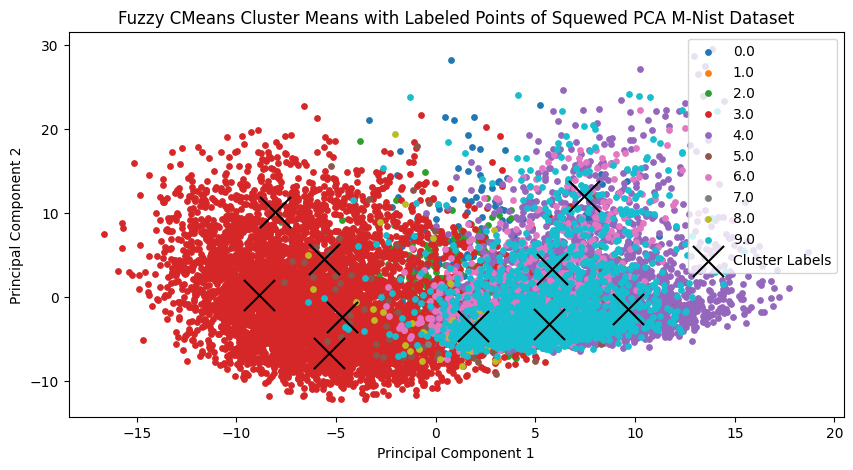

In [107]:
clusters = np.unique(y)

plt.figure(figsize=(10, 5))
for cl_num in np.unique(clusters):
    inds = np.where(y == cl_num)[0]
    plt.scatter(X_pca[inds,0],X_pca[inds,1], marker = 'o', s = 15, label = cl_num)

plt.scatter(pca_v[:, 0], pca_v[:,1], marker='x', c= 'black', s=500, label='Cluster Labels')
plt.legend()
plt.title('Fuzzy CMeans Cluster Means with Labeled Points of Squewed PCA M-Nist Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('./report/images/pca_cluster_means.png', dpi=300)


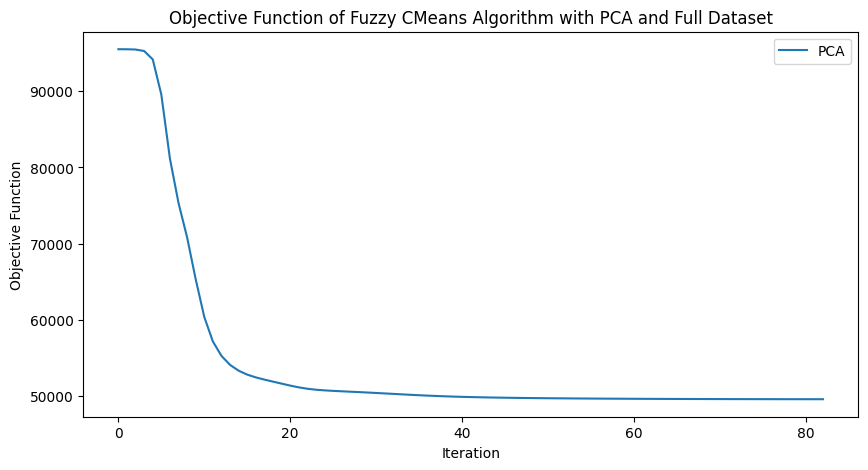

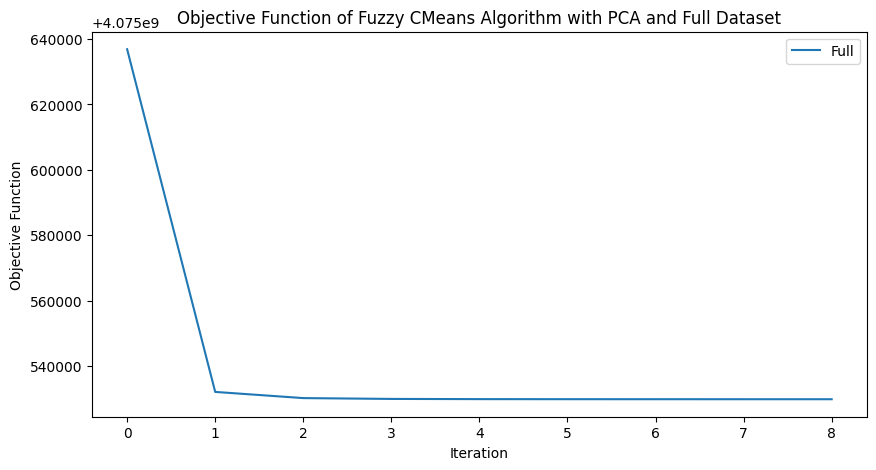

In [30]:
#plot pca_j and full_j

plt.figure(figsize=(10, 5))
plt.plot(pca_j[1:], label='PCA')
plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.legend()
plt.title('Objective Function of Fuzzy CMeans Algorithm with PCA and Full Dataset')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(full_j[1:], label='Full')
plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.legend()
plt.title('Objective Function of Fuzzy CMeans Algorithm with PCA and Full Dataset')
plt.show()



h:\dev\git\csc730\.venv\Lib\site-packages\sklearn\preprocessing\_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


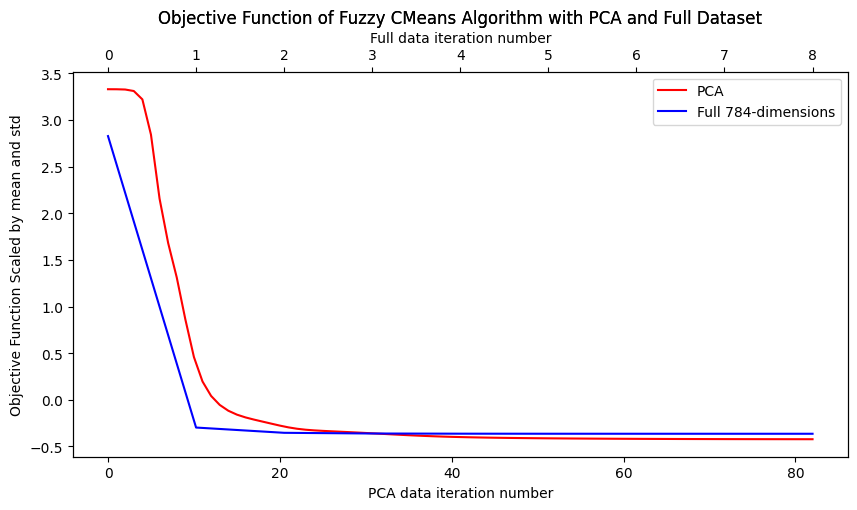

In [106]:
from sklearn.preprocessing import scale
#let's generate a twiny plot with the iteration time
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(scale(pca_j[1:], axis=0, with_mean=True, with_std=True), label='PCA', color='red')
ax1.set_xlabel('PCA data iteration number')
ax1.set_ylabel('Objective Function Scaled by mean and std')
#ax1.legend()

ax1.set_title('Objective Function of Fuzzy CMeans Algorithm with PCA and Full Dataset')

ax2 = ax1.twiny()
ax2.plot(scale(full_j[1:],axis=0, with_mean=True, with_std=True), label='Full 784-dimensions', color='blue')
ax2.set_xlabel('Full data iteration number')
ax2.set_ylabel('Objective Function Scaled by mean and std')
#axis x_ticks_labels needs to be replaced to go from 0 to 1



lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

ax2.set_title('Objective Function of Fuzzy CMeans Algorithm with PCA and Full Dataset')
plt.savefig('./report/images/objective_function_iterations.png', dpi=300)
plt.show()


In [36]:
#you will then write your own version of the Adjusted Rand Index algorithm (from scratch), and use it to score the results of your clustering on both versions of the data.
#The Adjusted Rand Index is a measure of the similarity between two data clusterings, and is often used to compare the results of clustering algorithms to a ground truth clustering.

def adjusted_rand_index(y, y_pred):    
   '''
    Function defined to calculate the Rand Index. This algorithm determines
    the simularities and differences in which points are either within the same cluster
    or not and compares both the true labels and predicted labels. This is required because
    predicted clusters are not assumed to be consistent.
    
    Inputs:
    
    y: True Labels
    y_pred: Predicted Labels
    
    '''
    
    # Initialize comparison values
   n_00 = 0.
   n_11 = 0.
   n_10 = 0.
   n_01 = 0.

   # Initialize comparison matrices
   true = np.zeros((len(y), len(y)))
   pred = np.zeros((len(y), len(y)))

   # Iterate through labels
   for i in range(true.shape[0]):
       # Iterate through labels
       for j in range(true.shape[0]):
           # Check if points in true labels are in same cluster
           if(y[i] == y[j]):
               true[i,j] = 1
            
            # Check if points in predicted labels are in same cluster
           if(y_pred[i] == y_pred[j]):
               pred[i,j] = 1

    # Iterate through upper triangular of true and predicted comparison matrix
   for i in range(true.shape[0]):
       for j in range(i+1, true.shape[1]):
           # Check if true index value is same as predicted index value
           if(true[i,j] == pred[i,j]):
               # Both are in same cluster 
               if(true[i,j] == 1):
                   n_11 += 1.
               # Both are not in same cluster
               else:
                   n_00 += 1.
           # Index values are not the same        
           else:
               # Same clusters in true but different clusters in pred
               if(true[i,j] == 1):
                   n_10 += 1.
               # Different clusters in true but same clusters in pred
               else:
                   n_01 += 1.
    # Calculate rand index value
   ari = (n_00 + n_11) / (n_00 + n_11 + n_10 + n_11)

   return ari


#use the adjusted_rand_index function to score the results of your clustering on both versions of the data.
RI_full = adjusted_rand_index(y, np.argmax(full_mu, axis=1))
RI_pca= adjusted_rand_index(y, np.argmax(pca_mu, axis=1))
print(f'RI of original data: {RI_full:.3f}')
print(f'RI of PCA data: {RI_pca:.3f}')




RI of original data: 0.692
RI of PCA data: 0.672


### PCA of Initial Data to 2 Dimensions

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

### Fuzzy CMeans Clustering

In [ ]:
def find_new_cluster_center(mu, p, m):
    '''
    Function Defined to find new cluster centers (V) using fuzzy matrix
    p( points ) and m (fuzzy constant)
    
    Inputs:
    
    mu: Old mu matrix containing previous fuzzy values, size = (n points, k clusters)
    p: Points of data, size = (n points, d dimensions)
    m: Fuzzy contant, scalar
    
    Outputs:
    
    v: Means of Clusters, each row represents the kth cluster, each column represents
        the d'th dimension
        shape = (k clusters, d dimensions)
    '''
    
    # Initialize v matrix
    v = np.zeros(shape = (mu.shape[1], p.shape[1]))
    
    # Iterate through clusters
    for k in range(mu.shape[1]):
        # Initialize numerator 
        numerator = np.zeros((1, p.shape[1]))
        
        # Iterate through points
        for n in range(p.shape[0]):
            # Multiply points by respective mu index using broadcasting (all p multiply by one mu index)
            numerator += np.power(mu[n,k], m) * p[n,:]
        
        # Sum all values of k'th cluster column in mu matrix    
        denominator = np.sum(np.power(mu[:,k], m))
        
        # Fill k'th cluster row in means matrix
        v[k, :] = numerator / denominator
    
    return v

In [ ]:
def update_fuzzy_matrix(mu, p, v, m):
    '''
    Function Defined to update fuzzy matrix which is used to determine
    probabilities of points being in each cluster
    
    Inputs:
    
    mu: Old mu matrix containing previous fuzzy values, size = (n points, k clusters)
    p: Points of data, size = (n points, d dimensions)
    v: Means of Clusters, each row represents the kth cluster, each column represents
        the d'th dimension, shape = (k clusters, d dimensions)
    m: Fuzzy contant, scalar
    
    Outputs:
    
    mu: Updated mu matrix containing previous fuzzy values, size = (n points, k clusters)
    
    '''
    
    # Determine power for denominator
    a = 2 / (m - 1)
    
    # Iterate through all points
    for n in range(p.shape[0]):
        # Iterate through all clusters
        for k in range(mu.shape[1]):
            # Determine numerator for k'th cluster
            num = np.linalg.norm(p[n,:] - v[k, :])
            
            # Initialize sum for the inside of brackets which gets taken to a power
            sum_inside = 0.
            
            # Iterate through all clusters again to represent summation
            for l in range(mu.shape[1]):
                # Find distance between points and cluster means
                den = np.linalg.norm(p[n,:] - v[l,:])
                inside = num / den
                sum_inside += np.power(inside, a)
                
            # Update index
            mu[n,k] = 1. / sum_inside
        
    return mu

In [ ]:
def fuzzy_cmeans_loss(mu, p, v, m):
    '''
    Function Defined to determine the loss for Fuzzy C-Means Clustering Algorithm
    
    Inputs:
    
    mu: Old mu matrix containing previous fuzzy values, size = (n points, k clusters)
    p: Points of data, size = (n points, d dimensions)
    v: Means of Clusters, each row represents the kth cluster, each column represents
        the d'th dimension, shape = (k clusters, d dimensions)
    m: Fuzzy contant, scalar
    
    Outputs:
    
    J: Loss of Fuzzy C-Means Clustering Alogorithm, Scalar
    
    '''
    
    # Initialize J
    J = 0
    
    # Iterate through points
    for n in range(p.shape[0]):
        # Iterate through clusters
        for k in range(mu.shape[1]):
            # Find squared distance of point from cluster mean
            norm_val = np.power(np.linalg.norm(p[n,:] - v[k,:]), 2)
            
            # Increment J each point and cluster
            J += np.power(mu[n,k], m) * norm_val
            
    return J

## FCM

In [ ]:
# Implment fuzzy c-means clustering from scratch

def fcm(X, n_clusters, max_iter=100, m=2, error=1e-5, random_state=42):
    '''
    Function Defined to determine to implement the Fuzzy C-Means Clustering Algorithm
    on the data X, into n_clusters 
    
    Inputs:
    
    X: Data to be clustered, shape = (n points, d dimensions)
    n_clusters: Scalar of amount of clusters
    max_iteration: Max iterations before exiting algorithm if not converged
    m: Scalar of fuzzy constant
    error: Scalar used to determine Convergence in Algorithm
    random_state: Fuzzy matrix is initially randomly generated, so random state 
                  allows replicability
    
    Outputs:
    
    mu: Final fuzzy matrix: size = (n points, k clusters)
    v: Final cluster means: size = (k clusters, d dimensions)
    
    '''
    # Initialize iteration tracker and loss list
    iter = 0
    J = [1000, 0]
    
    # Generate random fuzzy matrix of values between [0,1)
    mu = np.random.uniform(low=0.25, high=1, size=(X.shape[0], n_clusters))
    
    # Normalize rows to sum to 1, as probability being in all cluster must be 1
    for i in range(mu.shape[0]):
        mu[i,:] = mu[i,:] / np.sum(mu[i,:])
    
    # Iterate until convergence or max iteration hit
    while((np.abs(J[iter]- J[iter+1]) > error) and (iter < max_iter)):
        # Update cluster mean locations
        v = find_new_cluster_center(mu, X, m)
        
        # Calculate new fuzzy matrix
        mu = update_fuzzy_matrix(mu, X, v, m)
        
        # Determine loss for iteration and append to list
        J.append( fuzzy_cmeans_loss(mu, X, v, m) )
        
        # Increment iteration tracker
        iter += 1
        
        # Print to allow visual representation of where algorithm is when running
        print(f'Iteration: {iter},  J: {J[iter+1]:.6f}')
        
    return mu, v

In [ ]:
# Run FCM Clustering Algorthm
mu_pca, v_pca = fcm(X_pca, 10, 30)

Iteration: 1,  J: 95507.077003
Iteration: 2,  J: 95494.497680
Iteration: 3,  J: 95418.730856
Iteration: 4,  J: 94973.029019
Iteration: 5,  J: 92734.448140
Iteration: 6,  J: 86588.615974
Iteration: 7,  J: 79894.427166
Iteration: 8,  J: 75768.387246
Iteration: 9,  J: 72325.192929
Iteration: 10,  J: 68049.819201
Iteration: 11,  J: 63696.718789
Iteration: 12,  J: 60194.764874
Iteration: 13,  J: 57554.335156
Iteration: 14,  J: 55735.127817
Iteration: 15,  J: 54525.699261
Iteration: 16,  J: 53667.700354
Iteration: 17,  J: 53007.623069
Iteration: 18,  J: 52483.504267
Iteration: 19,  J: 52073.380488
Iteration: 20,  J: 51761.549118
Iteration: 21,  J: 51526.807458
Iteration: 22,  J: 51346.013078
Iteration: 23,  J: 51200.434021
Iteration: 24,  J: 51077.885696
Iteration: 25,  J: 50971.556285
Iteration: 26,  J: 50877.999667
Iteration: 27,  J: 50795.496480
Iteration: 28,  J: 50723.021618
Iteration: 29,  J: 50659.709379
Iteration: 30,  J: 50604.642075


## Plot PCA Data with Means

Text(0.5, 1.0, 'Fuzzy CMeans Cluster Means with Labeled Points of Squewed PCA M-Nist Dataset')

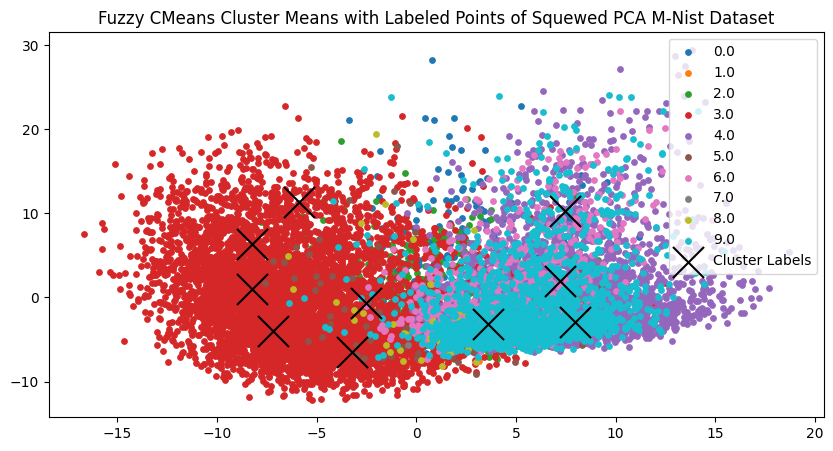

In [ ]:
clusters = np.unique(y)

plt.figure(figsize=(10, 5))
for cl_num in np.unique(clusters):
    inds = np.where(y == cl_num)[0]
    plt.scatter(X_pca[inds,0],X_pca[inds,1], marker = 'o', s = 15, label = cl_num)

plt.scatter(v_pca[:, 0], v_pca[:,1], marker='x', c= 'black', s=500, label='Cluster Labels')
plt.legend()
plt.title('Fuzzy CMeans Cluster Means with Labeled Points of Squewed PCA M-Nist Dataset')

In [ ]:
# Save means to csv file
v_pca_df = pandas.DataFrame(v_pca)
v_pca_df.to_csv('mu_pca.csv')

## Adjusted Rand Index

In [ ]:
def ARI(y, y_pred):
    '''
    Function defined to calculate the Rand Index. This algorithm determines
    the simularities and differences in which points are either within the same cluster
    or not and compares both the true labels and predicted labels. This is required because
    predicted clusters are not assumed to be consistent.
    
    Inputs:
    
    y: True Labels
    y_pred: Predicted Labels
    
    '''
    
    # Initialize comparison values
    n_00 = 0.
    n_11 = 0.
    n_10 = 0.
    n_01 = 0.
    
    # Initialize comparison matrices
    true = np.zeros((len(y), len(y)))
    pred = np.zeros((len(y), len(y)))
    
    # Iterate through labels
    for i in range(true.shape[0]):
        # Iterate through labels
        for j in range(true.shape[0]):
            # Check if points in true labels are in same cluster
            if(y[i] == y[j]):
                true[i,j] = 1
            
            # Check if points in predicted labels are in same cluster
            if(y_pred[i] == y_pred[j]):
                pred[i,j] = 1
    
    # Iterate through upper triangular of true and predicted comparison matrix
    for i in range(true.shape[0]):
        for j in range(i+1, true.shape[1]):
            # Check if true index value is same as predicted index value
            if(true[i,j] == pred[i,j]):
                # Both are in same cluster 
                if(true[i,j] == 1):
                    n_11 += 1.
                # Both are not in same cluster
                else:
                    n_00 += 1.
            # Index values are not the same        
            else:
                # Same clusters in true but different clusters in pred
                if(true[i,j] == 1):
                    n_10 += 1.
                # Different clusters in true but same clusters in pred
                else:
                    n_01 += 1.

    # Calculate rand index value
    ari = (n_00 + n_11) / (n_00 + n_11 + n_10 + n_11)
    
    return ari

In [ ]:
y_pred_pca = np.argmax(mu_pca, axis=1)

In [ ]:
ari_pca = ARI(y, y_pred_pca)
print(f'ARI Score for PCA FCMeans: {ari_pca:.4f}')

ARI Score for PCA FCMeans: 0.6710


## All Dimensions

In [ ]:
# Run FCM on scaled data with 784 dimensions
mu_all, v_all = fcm(X_scaled, 10, 10)

Iteration: 1,  J: 813026.546086
Iteration: 2,  J: 813001.921741
Iteration: 3,  J: 813001.637605
Iteration: 4,  J: 813001.606164
Iteration: 5,  J: 813001.601111
Iteration: 6,  J: 813001.600206
Iteration: 7,  J: 813001.600039
Iteration: 8,  J: 813001.600007
Iteration: 9,  J: 813001.600001


In [ ]:
# Save means to csv
v_all_df = pandas.DataFrame(v_all)
v_all_df.to_csv('mu_all.csv')

In [ ]:
# Print ARI for X_scaled data
y_pred_all = np.argmax(mu_all, axis=1)
ari_all = ARI(y, y_pred_all)
print(f'ARI Score for All Dimensions FCMeans: {ari_all:.4f}')

ARI Score for All Dimensions FCMeans: 0.6969
